In [1]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import kde

In [3]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load feature 2 data (salt bridges)

In [4]:
with np.load("../../data/raw_feat/feat2_raw.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [5]:
print(len(data))
print(data[0].shape)

1295
(3000, 60)


In [6]:
data_arr = np.concatenate(data)
print(data_arr.shape)

(6580000, 60)


## load CVs 

In [7]:
with np.load("../../data/raw_feat/cv_dist_spin.npz", allow_pickle=True) as f:
    cv_arr = f["arr_0"]

In [8]:
traj_lens = [len(traj) for traj in data]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)
cv_trajs = np.split(cv_arr, traj_inds)

In [9]:
cv_arr.shape

(6580000, 2)

In [10]:
# take only last 30 features (Cz - Cd distances)
data_cz = [traj[:, 30:] for traj in data]

## Models 

In [11]:
feat2_models = np.load("../../data/models_feat2.npy")

In [12]:
models_cz = feat2_models[:, 30:]

## Load IVAC data

In [13]:
livac_trajs = np.load("../../data/sb-livac.npy", allow_pickle=True)
print(livac_trajs.shape)
livac_arr = np.concatenate(livac_trajs)
print(livac_arr.shape)

(1295,)
(6580000, 5)


In [14]:
models_livac = np.load("../../data/models-livac.npy")

Load New version using Gaussian contact-transformed distances (4.26.21)

In [13]:
livac_trajs = np.load("../../data/sb-livac-gauss.npy", allow_pickle=True)
print(livac_trajs.shape)
livac_arr = np.concatenate(livac_trajs)
print(livac_arr.shape)
models_livac = np.load("../../data/models-livac-gauss.npy")

(1295,)
(6580000, 5)


# Averages on iTICs 

4.22.21

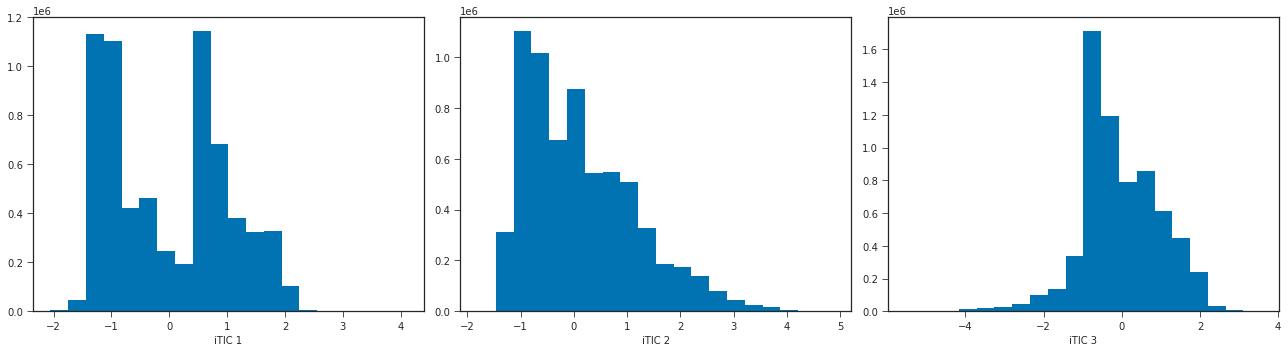

In [14]:
f, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axs):
    ax.hist(livac_arr[:, i + 1], bins=20)
    ax.set_xlabel(f"iTIC {i+1}")
f.tight_layout()

# States

In [15]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]

# centers of states based off initial crystal structure/homology models
# ellipse centered at (-8.919, -109.9) with radii 0.632 and 9.8 for down - state
downmin_ids = (
    (((dist + 8.919) / 0.632) ** 2 + ((rot + 109.9) / 9.8) ** 2) < 1
).nonzero()[0]

# ellipse centered at (-4.174 , -50.8) with radii 0.574 and 8.21 (1 sigma in each direction) for down state
down_ids = ((((dist + 4.174) / 0.574) ** 2 + ((rot + 50.8) / 8.21) ** 2) < 1).nonzero()[
    0
]

# ellipse centered at (0, 0) with radii 0.460 and 2.9 for up state
up_ids = (((dist / 0.460) ** 2 + (rot / 2.9) ** 2) < 1).nonzero()[0]

# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
upplus_ids = (
    (((dist - 4.535) / 0.632) ** 2 + ((rot - 43.7) / 4.0) ** 2) < 1
).nonzero()[0]

In [16]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[downmin_ids] = False
mask[down_ids] = False
mask[up_ids] = False
mask[upplus_ids] = False

# len(**_ids) is number of points in each state
downmin = data_arr[downmin_ids]
down = data_arr[down_ids]
up = data_arr[up_ids]
upplus = data_arr[upplus_ids]
other = data_arr[mask]

# split CV data
downmin_cvs = cv_arr[downmin_ids]
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
upplus_cvs = cv_arr[upplus_ids]
other_cvs = cv_arr[mask]

In [17]:
assert (len(downmin) + len(down) + len(up) + len(upplus) + len(other)) == len(cv_arr)
print(f"Number of down- structures: {len(downmin)}")
print(f"Number of down structures:  {len(down)}")
print(f"Number of up structures:    {len(up)}")
print(f"Number of up+ structures:   {len(upplus)}")
print(f"Number of other structures: {len(other)}")

Number of down- structures: 1536
Number of down structures:  56676
Number of up structures:    62403
Number of up+ structures:   54524
Number of other structures: 6404861


## IVAC split 

In [18]:
downmin_livac = livac_arr[downmin_ids]
down_livac = livac_arr[down_ids]
up_livac = livac_arr[up_ids]
upplus_livac = livac_arr[upplus_ids]

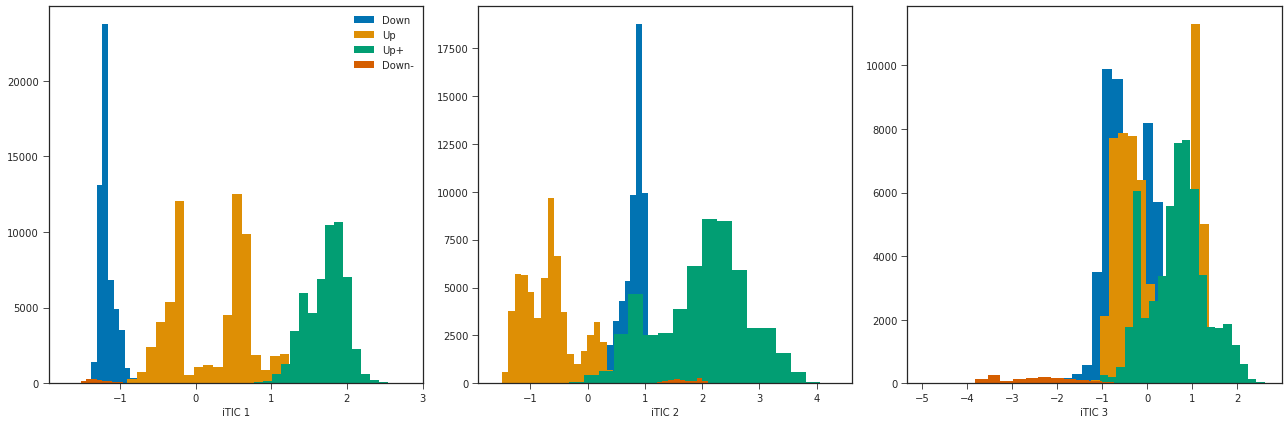

In [19]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    for state in (down_livac, up_livac, upplus_livac, downmin_livac):
        ax.hist(state[:, i + 1], bins=20)
    ax.set_xlabel(f"iTIC {i + 1}")

axs[0].legend(["Down", "Up", "Up+", "Down-"])
f.tight_layout()

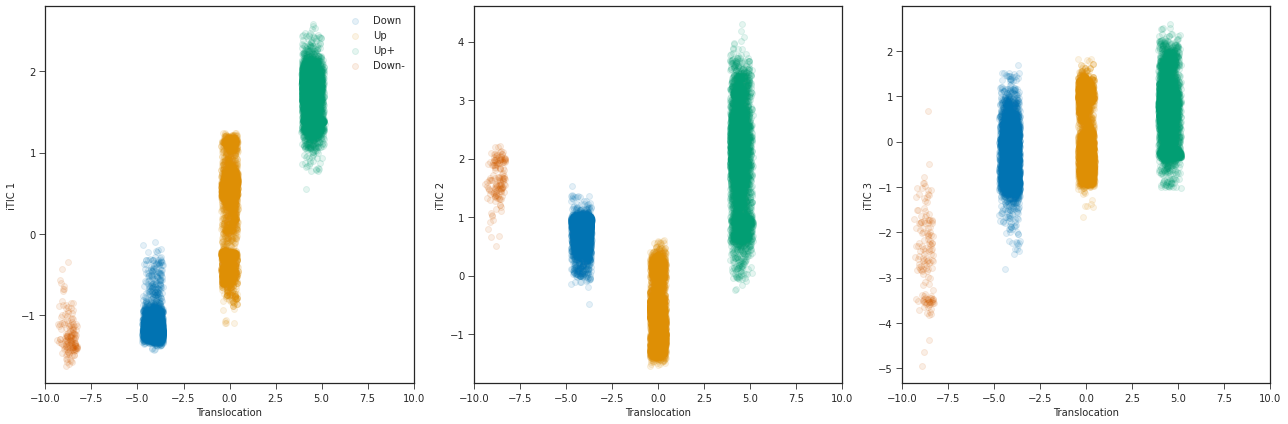

In [20]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    for cv_group, state in zip(
        (down_cvs, up_cvs, upplus_cvs, downmin_cvs),
        (down_livac, up_livac, upplus_livac, downmin_livac),
    ):
        ax.scatter(cv_group[::10, 0], state[::10, i + 1], alpha=0.1)

    axs[0].legend(["Down", "Up", "Up+", "Down-"])
    ax.set_xlim([-10, 10])
    ax.set_xlabel("Translocation")
    ax.set_ylabel(f"iTIC {i + 1}")

f.tight_layout()

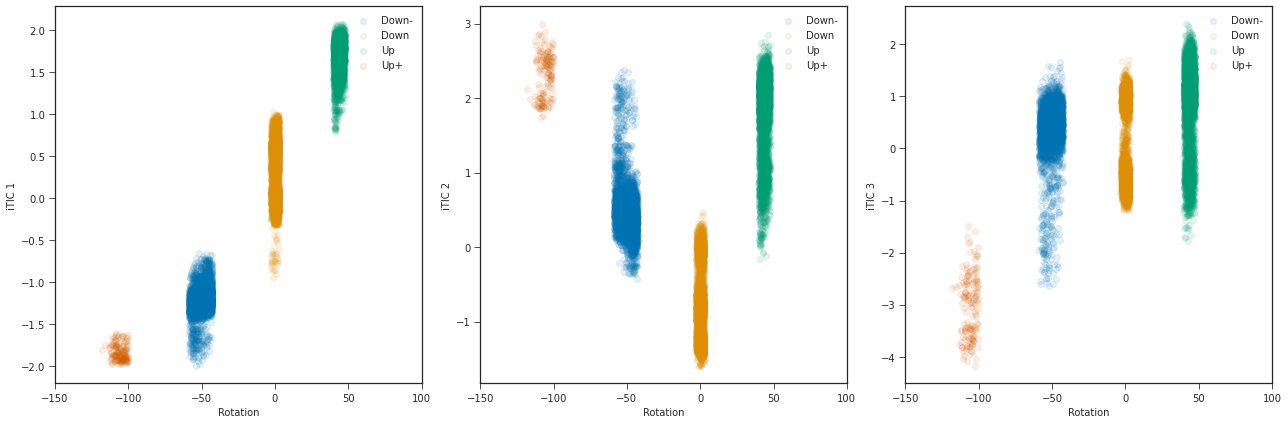

In [42]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    for cv_group, state in zip(
        (down_cvs, up_cvs, upplus_cvs, downmin_cvs),
        (down_livac, up_livac, upplus_livac, downmin_livac),
    ):
        ax.scatter(cv_group[::10, 1], state[::10, i + 1], alpha=0.1)

    ax.legend(["Down-", "Down", "Up", "Up+"])
    ax.set_xlim([-150, 100])
    ax.set_xlabel("Rotation")
    ax.set_ylabel(f"iTIC {i + 1}")

f.tight_layout()

In [57]:
%matplotlib inline

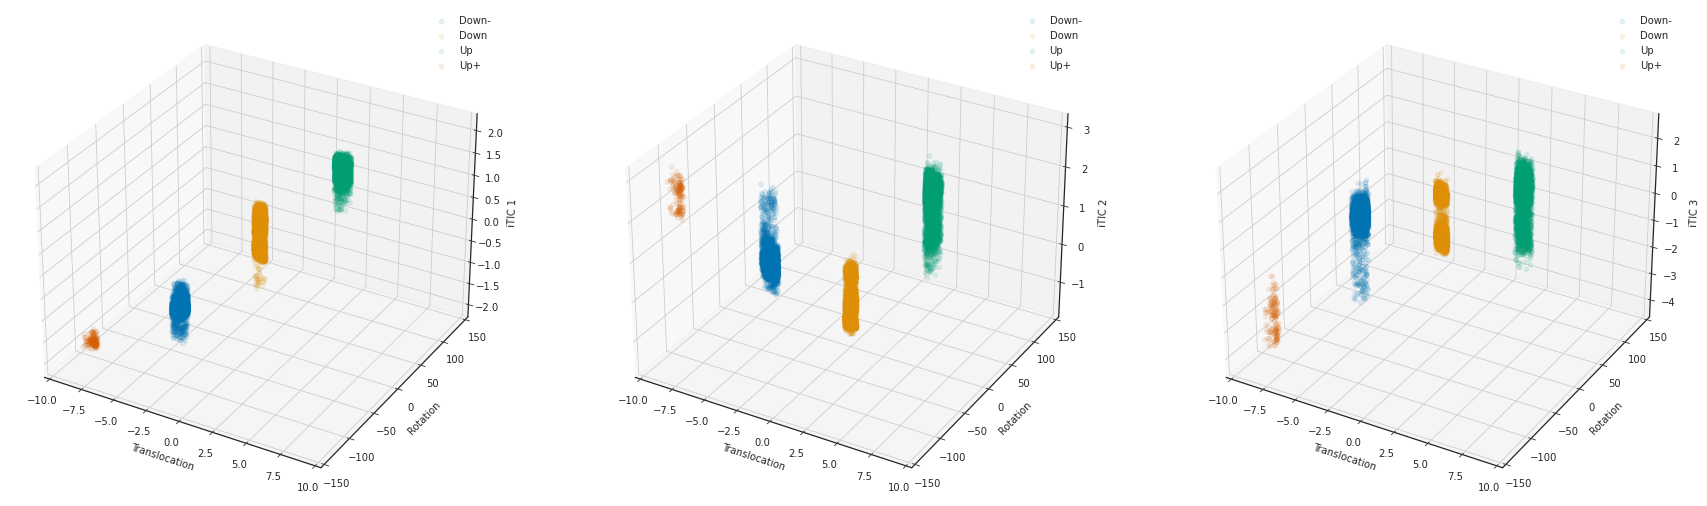

In [60]:
f, axs = plt.subplots(1, 3, figsize=(30, 10), subplot_kw={"projection": "3d"})
for i, ax in enumerate(axs):
    for cv_group, state in zip(
        (down_cvs, up_cvs, upplus_cvs, downmin_cvs),
        (down_livac, up_livac, upplus_livac, downmin_livac),
    ):
        ax.scatter(cv_group[::10, 0], cv_group[::10, 1], state[::10, i + 1], alpha=0.1)
    ax.legend(["Down-", "Down", "Up", "Up+"])
    ax.set_xlim([-10, 10])
    ax.set_ylim([-150, 150])
    ax.set_xlabel("Translocation")
    ax.set_ylabel("Rotation")
    ax.set_zlabel(f"iTIC {i + 1}")

In [21]:
from itertools import combinations

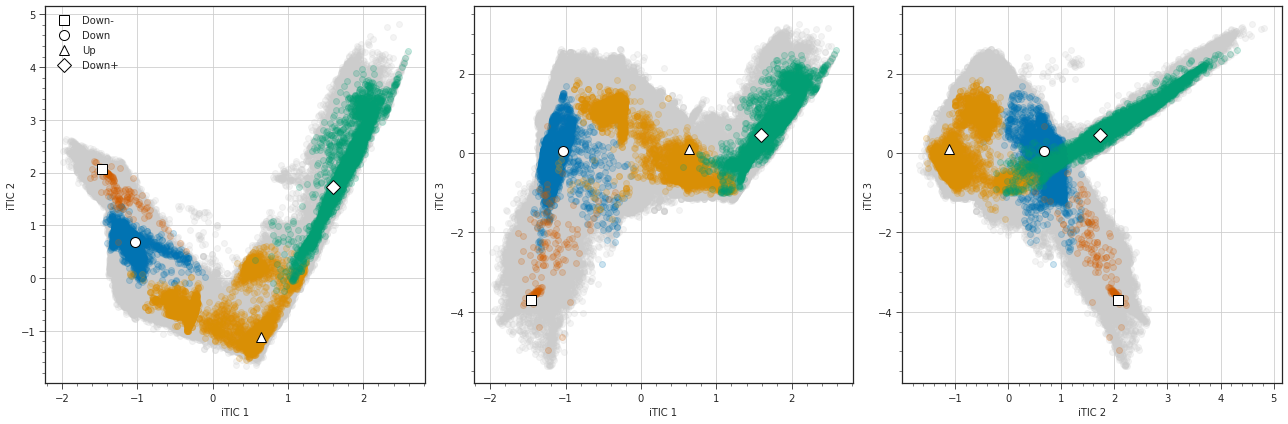

In [23]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for (i, j), ax in zip(combinations(range(1, 4), 2), axs):
    ax.scatter(livac_arr[::20, i], livac_arr[::20, j], c="0.8", alpha=0.2)
    for state in (down_livac, up_livac, upplus_livac, downmin_livac):
        ax.scatter(state[::10, i], state[::10, j], alpha=0.2)

    ax.set_xlabel(f"iTIC {i}")
    ax.set_ylabel(f"iTIC {j}")
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.grid()

util.plot_models(axs[0], models_livac[:, 1:3])
util.plot_models(axs[1], models_livac[:, 1:4:2])
util.plot_models(axs[2], models_livac[:, 2:4])
axs[0].legend(["Down-", "Down", "Up", "Down+"])

f.tight_layout()

# plt.savefig('../../fig/ivac-sb-iTIC-states-dens', dpi=300)

## Look at outlying states 

4.23.21

In [24]:
dist_1 = (
    (downmin_livac[:, 1] + 1.8) ** 2
).argsort()  # iTIC = -1.9, near down-/down states
print(downmin_ids[dist_1[:10]])
dist_2 = ((down_livac[:, 1] + 1.8) ** 2).argsort()
print(down_ids[dist_2[:10]])

[4640739 4640687 4640563 4551037 4640755 4640722 4641112 2076829 4640648
 4641017]
[4625762 4626106 4625945 4625239 4626216 4625833 4625750 4626329 4627484
 4626730]


4.26.21

In [24]:
dist_3 = (
    (up_livac[:, 1] + 0.4) ** 2
).argsort()  # iTIC 1 = -0.4, another peak in up state
dist_4 = (
    (down_livac[:, 1] + 0.4) ** 2
).argsort()  # same as above, but looking at overlap in down state
dist_5 = ((up_livac[:, 1] - 1.1) ** 2).argsort()  # up/up+ state overlapping
dist_6 = ((upplus_livac[:, 1] - 1.1) ** 2).argsort()
dist_7 = (
    (downmin_livac[:, 1] + 1.0) ** 2
).argsort()  # down- states which are overlapping with down
print(up_ids[dist_3[:10]])
print(down_ids[dist_4[:10]])
print(up_ids[dist_5[:10]])
print(upplus_ids[dist_6[:10]])
print(downmin_ids[dist_7[:10]])

[6288656 6393539 6363539 5743539 6193539 6393288 6363288 5743288 6193288
 6288430]
[4072759 4076724 4628286 4628016 3551322 4073879 4628099 4076579 4626928
 4623383]
[2123783 2811528 2363208 2871697 2363589 3835653 2721190 2961754 2123320
 2872973]
[3475017 1450116 3394612 4397996 3394594 2048985 3478312 3478382 2048743
 1451273]
[1189916 1190676 1189810 1190703 4649526    1396 1189805 1077703 2076733
 4506209]


In [53]:
dist_8 = (
    (up_livac[:, 1] + 0.8) ** 2
).argsort()  # iTIC 1 = -1.2, another peak in up state
dist_9 = (
    (down_livac[:, 1] + 0.8) ** 2
).argsort()  # same as above, but looking at overlap in down state
print(up_ids[dist_8[:10]])
print(down_ids[dist_9[:10]])

[6392029 6362029 6192029 5742029 4843022 4854697 5744299 6394299 6194299
 6364299]
[3620382 4545262 4738224  210105 4626216 4812755 4030312 4074072 4626125
 3552767]


In [72]:
dist_10 = ((down_livac[:, 1] + 1.4) ** 2).argsort()  # left side of down state
print(down_ids[dist_10[:10]])

[1184487 1184577 4158595 4158594 1184576 1184545 4158633 2045641 1184453
 4158623]


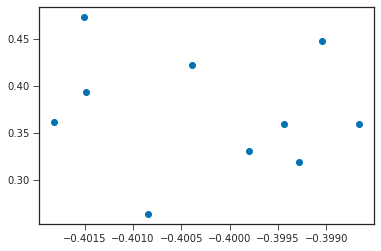

In [40]:
plt.plot(livac_arr[down_ids[dist_4[:10]], 1], livac_arr[down_ids[dist_4[:10]], 2], "o")

In [77]:
util.frame(1184545)

(394, 2545)

Up states with iTIC > 1 seem to be a transitory state towards the up+ state, the R226 is stuck in the hydrophobic plug

Up+ with iTIC ~ 1.1: should probably be not included - R3 not sticking all the way up

Down state with iTIC ~ -0.4 includes some strangely "expanded" states where the S4 and/or S1 is further away

Up states with iTIC ~ 0.4 seems pretty reasonable - maybe the down state needs to be shrunk

Down states iTIC ~ -1.4 are reasonable, up states near there are basically down, so should choose lower bound for up state 

Down states iTIC ~ -0.8 are also strangely "expanded"

Down- states iTIC ~ -1.0: somewhat R1 pointing up

# new states 

Down to up+ transition

In [31]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = livac_arr[:, 1]

# ellipse centered at (-4.174 , -50.8) with radii 0.574 and 8.21 (1 sigma in each direction) for down state
# take points where TIC 1 > -1.5
dist_ax_down = (dist + 4.174) / 0.57
rot_ax_down = (rot + 50.8) / 8.21
down_ids_2 = (((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (tic1 > -1.5)).nonzero()[0]

# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 > 1.1
dist_ax_upp = (dist - 4.535) / 0.632
rot_ax_upp = (rot - 43.7) / 4.0
upplus_ids_2 = (((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (tic1 > 1.1)).nonzero()[0]

In [32]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[down_ids_2] = False
mask[upplus_ids_2] = False

# len(**_ids) is number of points in each state
down = data_arr[down_ids_2]
upplus = data_arr[upplus_ids_2]
other = data_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids_2]
upplus_cvs = cv_arr[upplus_ids_2]
other_cvs = cv_arr[mask]

In [33]:
assert (len(down) + len(upplus) + len(other)) == len(cv_arr)
print(f"Number of down structures:  {len(down)}")
print(f"Number of up+ structures:   {len(upplus)}")
print(f"Number of other structures: {len(other)}")

Number of down structures:  54647
Number of up+ structures:   54016
Number of other structures: 6471337


## plot new states 

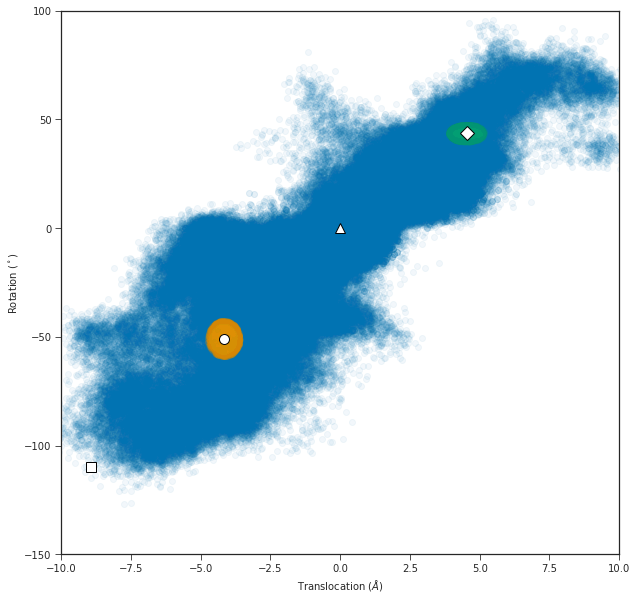

In [34]:
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(*other_cvs[::20].T, alpha=0.05)
for cv_group in (down_cvs, upplus_cvs):
    ax.scatter(*cv_group[::20].T, alpha=0.1)
util.format_cvs(ax)

In [36]:
down_livac = livac_arr[down_ids_2]
upplus_livac = livac_arr[upplus_ids_2]
other_livac = livac_arr[mask]

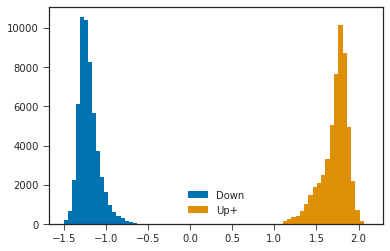

In [43]:
plt.hist(down_livac[:, 1], bins=20)
plt.hist(upplus_livac[:, 1], bins=20)
plt.legend(["Down", "Up+"])

(array([3.23000e+02, 1.24420e+04, 7.39880e+04, 1.21670e+05, 1.08956e+05,
        1.07620e+05, 9.96740e+04, 9.24390e+04, 8.99220e+04, 1.22935e+05,
        1.38292e+05, 1.74379e+05, 1.92630e+05, 1.96845e+05, 2.46819e+05,
        2.67293e+05, 2.27704e+05, 1.46133e+05, 1.50195e+05, 1.82582e+05,
        1.43810e+05, 1.04653e+05, 1.12505e+05, 1.16741e+05, 1.31270e+05,
        1.00835e+05, 6.34700e+04, 9.40800e+04, 1.49766e+05, 2.52473e+05,
        4.53525e+05, 4.63121e+05, 2.99686e+05, 1.56490e+05, 8.64960e+04,
        6.65840e+04, 8.31180e+04, 9.62600e+04, 8.82390e+04, 7.97560e+04,
        7.49020e+04, 6.39200e+04, 8.30170e+04, 1.04907e+05, 8.69700e+04,
        9.66540e+04, 5.00630e+04, 1.27020e+04, 2.37900e+03, 1.04000e+02]),
 array([-2.0745716 , -1.98650472, -1.89843784, -1.81037096, -1.72230407,
        -1.63423719, -1.54617031, -1.45810343, -1.37003654, -1.28196966,
        -1.19390278, -1.1058359 , -1.01776901, -0.92970213, -0.84163525,
        -0.75356837, -0.66550148, -0.5774346 , -0

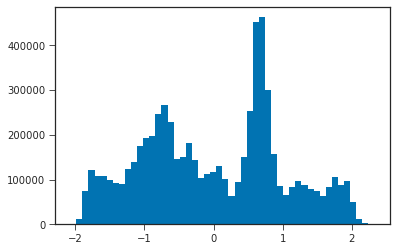

In [44]:
plt.hist(other_livac[:, 1], bins=50)

Text(0.5, 0, 'Rotation')

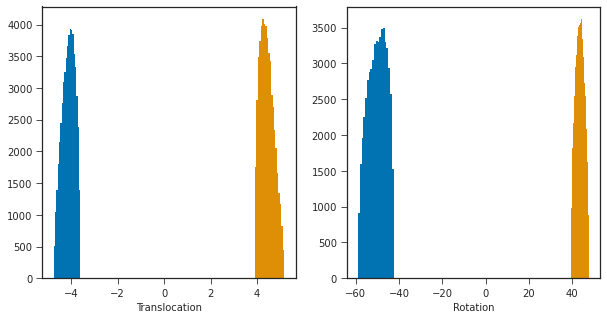

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(down_cvs[:, 0], bins=20)
ax1.hist(upplus_cvs[:, 0], bins=20)
ax1.set_xlabel("Translocation")
ax2.hist(down_cvs[:, 1], bins=20)
ax2.hist(upplus_cvs[:, 1], bins=20)
ax2.set_xlabel("Rotation")

In [46]:
# salt bridges used for ABMD (Cz-Cg distances)
sb0 = 30  # R217 - D129
sb1 = 40  # R223 - D186
sb2 = 43  # R226 - D136
sb3 = 48  # R229 - D129
sb4 = 58  # R232 - D186
sbs = (sb0, sb1, sb2, sb3, sb4)

In [48]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "D186", "E183"):
        sb_labels.append(f"{r} - {n}")

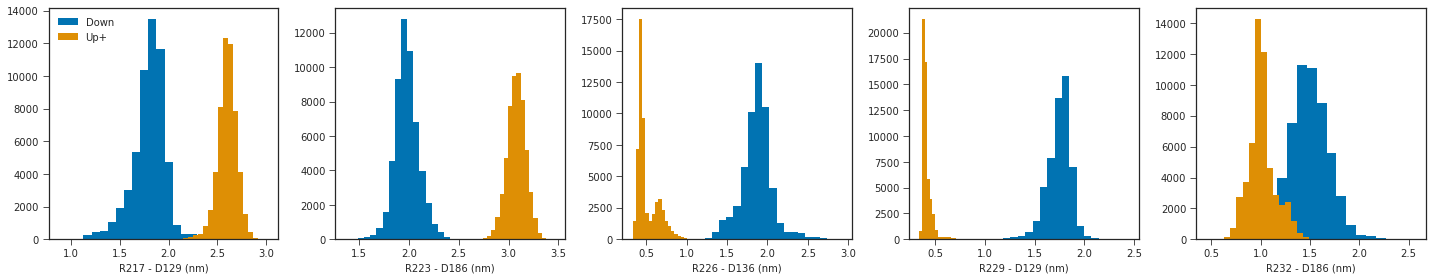

In [49]:
f, axs = plt.subplots(1, 5, figsize=(20, 4))
for ax, idx in zip(axs, sbs):
    ax.hist(down[:, idx], bins=20)
    ax.hist(upplus[:, idx], bins=20)
    ax.set_xlabel(f"{sb_labels[idx - 30]} (nm)")

axs[0].legend(["Down", "Up+"])
f.tight_layout()

In [50]:
%matplotlib widget

In [51]:
f, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
for cv_group, state in zip(
    (other_cvs, down_cvs, upplus_cvs), (other_livac, down_livac, upplus_livac)
):
    ax.scatter(cv_group[::10, 0], cv_group[::10, 1], state[::10, 1], alpha=0.1)
ax.legend(["Other", "Down", "Up+"])
ax.set_xlim([-10, 10])
ax.set_ylim([-150, 150])
ax.set_xlabel("Translocation")
ax.set_ylabel("Rotation")
ax.set_zlabel(f"iTIC {1}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'iTIC 1')

# New states rd 2 (4.26.21) 

In [78]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = livac_arr[:, 1]

# ellipse centered at (-4.174 , -50.8) with radii 0.574 and 8.21 (1 sigma in each direction) for down state
# take points where TIC 1 < -0.9
dist_ax_down = (dist + 4.174) / 0.57
rot_ax_down = (rot + 50.8) / 8.21
down_ids_2 = (((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (tic1 < -0.9)).nonzero()[0]

# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 > 1.1
dist_ax_upp = (dist - 4.535) / 0.632
rot_ax_upp = (rot - 43.7) / 4.0
upplus_ids_2 = (((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (tic1 > 1.2)).nonzero()[0]

In [79]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[down_ids_2] = False
mask[upplus_ids_2] = False

# len(**_ids) is number of points in each state
down = data_arr[down_ids_2]
upplus = data_arr[upplus_ids_2]
other = data_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids_2]
upplus_cvs = cv_arr[upplus_ids_2]
other_cvs = cv_arr[mask]

In [80]:
assert (len(down) + len(upplus) + len(other)) == len(cv_arr)
print(f"Number of down structures:  {len(down)}")
print(f"Number of up+ structures:   {len(upplus)}")
print(f"Number of other structures: {len(other)}")

Number of down structures:  54022
Number of up+ structures:   53027
Number of other structures: 6472951


## plot new states 

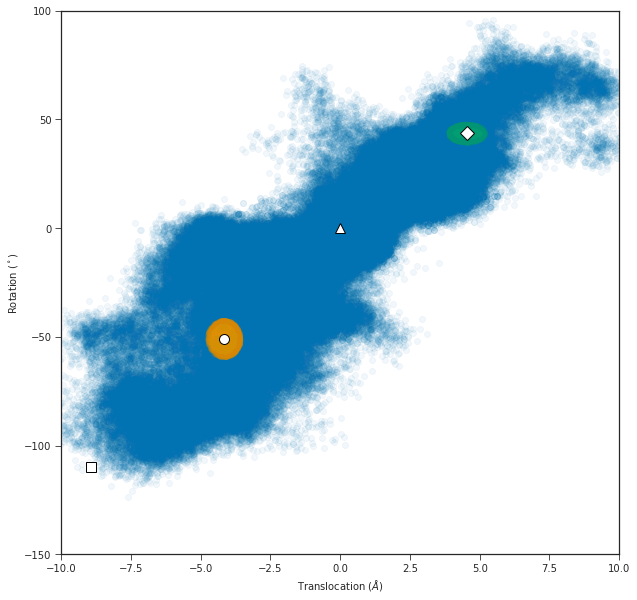

In [81]:
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(*other_cvs[::20].T, alpha=0.05)
for cv_group in (down_cvs, upplus_cvs):
    ax.scatter(*cv_group[::20].T, alpha=0.1)
util.format_cvs(ax)

In [82]:
down_livac = livac_arr[down_ids_2]
upplus_livac = livac_arr[upplus_ids_2]
other_livac = livac_arr[mask]

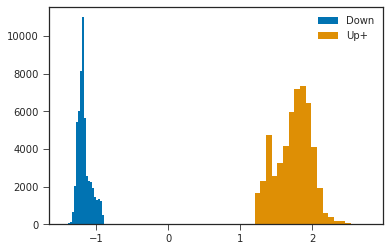

In [83]:
plt.hist(down_livac[:, 1], bins=20)
plt.hist(upplus_livac[:, 1], bins=20)
plt.legend(["Down", "Up+"])

Text(0.5, 0, 'Rotation')

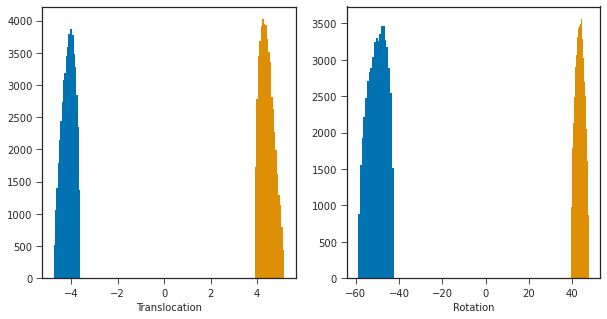

In [84]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(down_cvs[:, 0], bins=20)
ax1.hist(upplus_cvs[:, 0], bins=20)
ax1.set_xlabel("Translocation")
ax2.hist(down_cvs[:, 1], bins=20)
ax2.hist(upplus_cvs[:, 1], bins=20)
ax2.set_xlabel("Rotation")

In [85]:
%matplotlib widget

In [86]:
f, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
for cv_group, state in zip(
    (other_cvs, down_cvs, upplus_cvs), (other_livac, down_livac, upplus_livac)
):
    ax.scatter(cv_group[::10, 0], cv_group[::10, 1], state[::10, 1], alpha=0.1)
ax.legend(["Other", "Down", "Up+"])
ax.set_xlim([-10, 10])
ax.set_ylim([-150, 150])
ax.set_xlabel("Translocation")
ax.set_ylabel("Rotation")
ax.set_zlabel(f"iTIC {1}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'iTIC 1')

# Pairwise distances

In [87]:
%matplotlib inline

In [88]:
print(sklearn.get_config()["working_memory"])

1024


In [89]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

In [90]:
d_down = []
counter = 0.0
tot = len(data_arr)
skip = 3

for chunk in metrics.pairwise_distances_chunked(
    data_arr, down[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_down.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.11% completed
0.23% completed
0.34% completed
0.45% completed
0.57% completed
0.68% completed
0.79% completed
0.91% completed
1.02% completed
1.13% completed
1.25% completed
1.36% completed
1.47% completed
1.59% completed
1.70% completed
1.81% completed
1.93% completed
2.04% completed
2.15% completed
2.27% completed
2.38% completed
2.49% completed
2.61% completed
2.72% completed
2.83% completed
2.94% completed
3.06% completed
3.17% completed
3.28% completed
3.40% completed
3.51% completed
3.62% completed
3.74% completed
3.85% completed
3.96% completed
4.08% completed
4.19% completed
4.30% completed
4.42% completed
4.53% completed
4.64% completed
4.76% completed
4.87% completed
4.98% completed
5.10% completed
5.21% completed
5.32% completed
5.44% completed
5.55% completed
5.66% completed
5.78% completed
5.89% completed
6.00% completed
6.12% completed
6.23% completed
6.34% completed
6.46% completed
6.57% completed
6.68% completed
6.80% completed
6.91% completed
7.02% completed
7.14% co

In [91]:
print(len(d_down), d_down[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_down_arr = np.reshape(np.concatenate(d_down), (-1, 1))
print(d_down_arr.shape)
print(np.max(d_down_arr[down_ids]))
d_down_arr[down_ids] = 0
print(np.max(d_down_arr[down_ids]))

print(d_down_arr.shape)

883 (7453,)
(6580000, 1)
1.9287713
0.0
(6580000, 1)


In [93]:
np.save("../../data/dist_down_du_feat2_TIC", d_down_arr)

## Up+state

In [117]:
d_up = []
counter = 0.0

for chunk in metrics.pairwise_distances_chunked(
    data_arr, upplus[::skip], n_jobs=20, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.12% completed
0.23% completed
0.35% completed
0.46% completed
0.58% completed
0.69% completed
0.81% completed
0.92% completed
1.04% completed
1.15% completed
1.27% completed
1.38% completed
1.50% completed
1.62% completed
1.73% completed
1.85% completed
1.96% completed
2.08% completed
2.19% completed
2.31% completed
2.42% completed
2.54% completed
2.65% completed
2.77% completed
2.88% completed
3.00% completed
3.12% completed
3.23% completed
3.35% completed
3.46% completed
3.58% completed
3.69% completed
3.81% completed
3.92% completed
4.04% completed
4.15% completed
4.27% completed
4.39% completed
4.50% completed
4.62% completed
4.73% completed
4.85% completed
4.96% completed
5.08% completed
5.19% completed
5.31% completed
5.42% completed
5.54% completed
5.65% completed
5.77% completed
5.89% completed
6.00% completed
6.12% completed
6.23% completed
6.35% completed
6.46% completed
6.58% completed
6.69% completed
6.81% completed
6.92% completed
7.04% completed
7.15% completed
7.27% co

In [118]:
print(len(d_up), d_up[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
print(d_up_arr.shape)
print(np.max(d_up_arr[upplus_ids]))
d_up_arr[upplus_ids] = 0
print(np.max(d_up_arr[up_ids]))

print(d_up_arr.shape)

867 (7593,)
(6580000, 1)
1.3607235
4.5089703
(6580000, 1)


In [119]:
np.save("../../data/dist_up_duu_feat2_TIC.npy", d_up_arr)

# Smoothing and guess functions 

In [120]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr / (d_down_arr + d_up_arr)) ** 2
guess_up = (d_down_arr / (d_down_arr + d_up_arr)) ** 2

# make smoothing 0 at boundaries (dimer and monomer states)
smooth[(mask == 0).flatten()] = 0
# ensure homogeneous boundary conditions for guess
guess_up[upplus_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[upplus_ids] = 0

In [121]:
print(smooth.shape, guess_down.shape, guess_up.shape)

(6580000, 1) (6580000, 1) (6580000, 1)


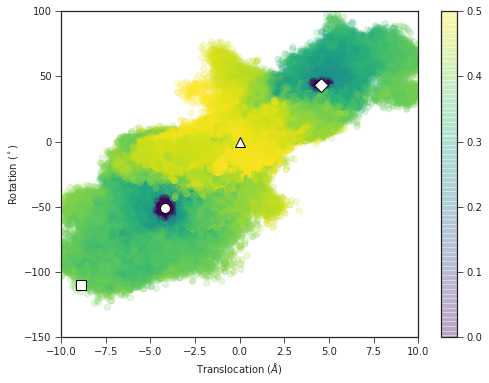

In [122]:
# Plot smoothing function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=smooth[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

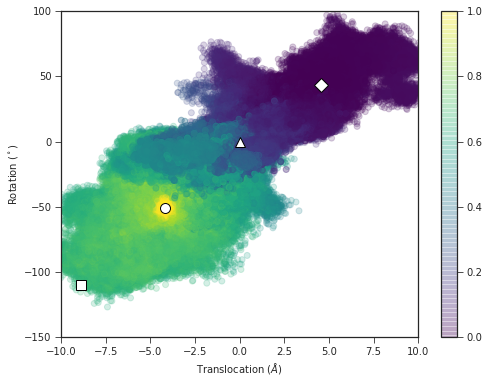

In [123]:
# Plot down state guess function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=guess_down[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

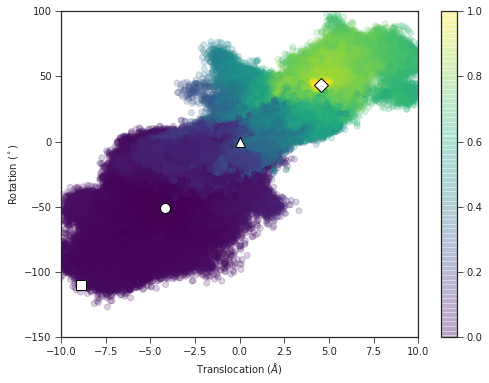

In [124]:
# Plot up+ state guess function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=guess_up[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

## Construct bases

In [125]:
basis_smooth = smooth * data_arr
print(basis_smooth.shape)
basis_white, L = util.svd_whiten(basis_smooth, 1, frac_retain=0.75)
basis_white[(mask == 0).flatten()] = 0

(6580000, 60)


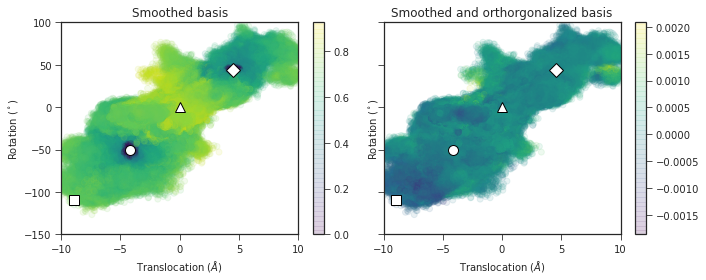

In [127]:
# plot bases
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
h1 = ax1.scatter(
    cv_arr[::10, 0],
    cv_arr[::10, 1],
    c=np.mean(basis_smooth[::10, :], axis=1),
    alpha=0.1,
    cmap="viridis",
)
h2 = ax2.scatter(
    cv_arr[::10, 0],
    cv_arr[::10, 1],
    c=np.mean(basis_white[::10, :], axis=1),
    alpha=0.1,
    cmap="viridis",
)
for ax in (ax1, ax2):
    util.format_cvs(ax)
ax1.set_title("Smoothed basis")
ax2.set_title("Smoothed and orthorgonalized basis")
plt.colorbar(h1, ax=ax1)
plt.colorbar(h2, ax=ax2)
f.tight_layout()

In [128]:
np.save("../../data/basis_white_duu_feat2_TICA.npy", basis_white)
np.save("../../data/guess_down_duu_feat2_TICA.npy", guess_down)
np.save("../../data/guess_up_duu_feat2_TICA.npy", guess_up)

## Convert to lists of np arrays 

In [129]:
const = np.ones((len(data_arr), 1))
basisL_arr = np.hstack((const, data_arr))
basisF_arr = basis_white

# basisL = np.split(basisL_arr, traj_inds)
basisL = np.split(data_arr, traj_inds)
basisF = np.split(basisF_arr, traj_inds)
guessU = np.split(np.squeeze(guess_up), traj_inds)
guessD = np.split(np.squeeze(guess_down), traj_inds)

print(len(basisL), basisL[0].shape)
print(len(basisF), basisF[0].shape)
print(len(guessU))
print(len(guessD))

1295 (3000, 60)
1295 (3000, 2)
1295
1295


# Change of Measure

In [130]:
# unit is 0.1 ps, up to 100 ns
lags = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000]

In [132]:
weights = np.load("../../data/feat2_local_duu/coms_feat2.npy", allow_pickle=True)

# Committors 

In [133]:
in_domain = np.split(mask, traj_inds)
q_downup, qb_downup, q_updown, qb_updown = [], [], [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))
    q_updown.append(extq.dga.forward_committor(basisF, com, in_domain, guessD, lag))
    qb_updown.append(extq.dga.backward_committor(basisF, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 30
Calculating committors for lag 40
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 300
Calculating committors for lag 400
Calculating committors for lag 500
Calculating committors for lag 1000


In [134]:
np.save("../../data/q_du_feat2_TICA.npy", q_downup)
np.save("../../data/qb_du_feat2_TICA.npy", qb_downup)
np.save("../../data/q_ud_feat2_TICA.npy", q_updown)
np.save("../../data/qb_ud_feat2_TICA.npy", qb_updown)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## Down-> up+ transition 

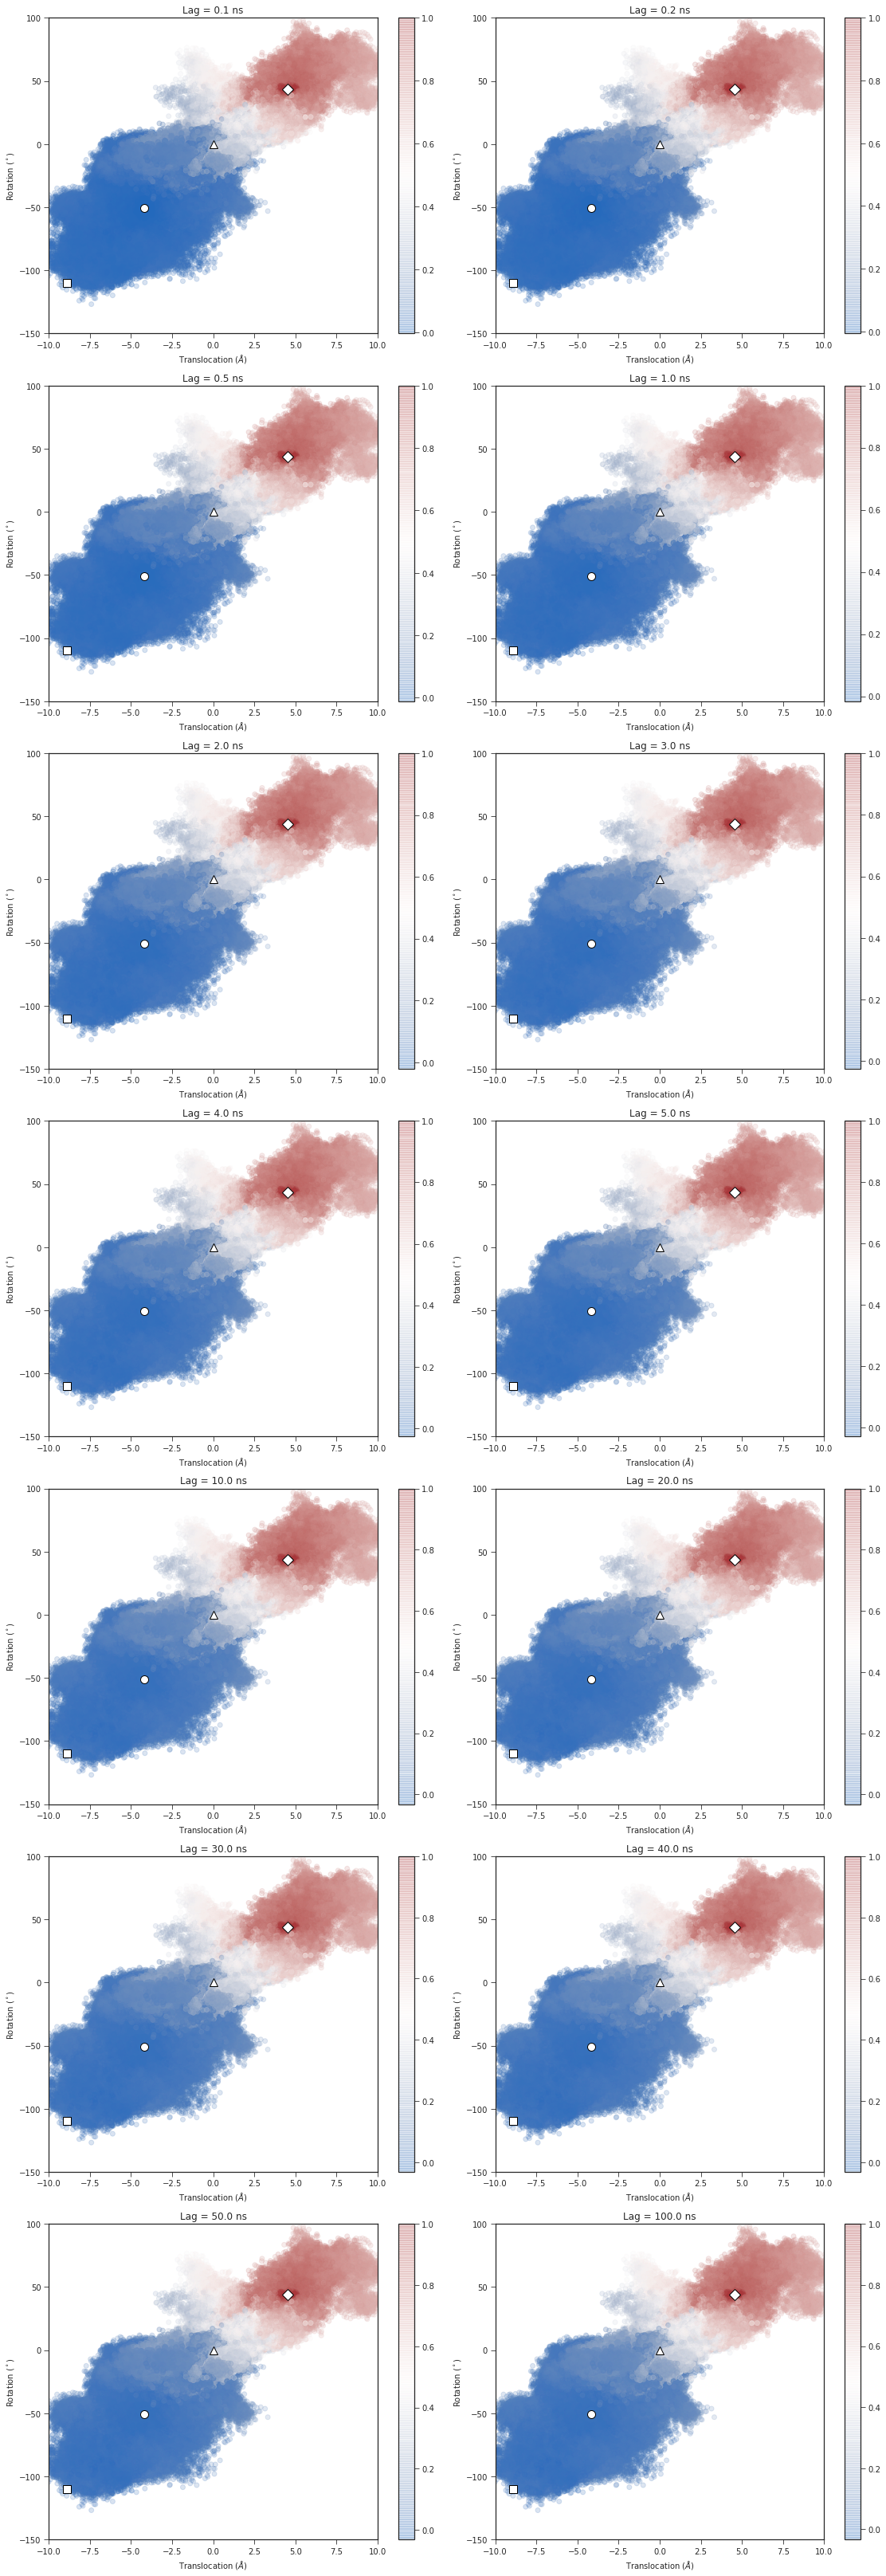

In [139]:
f, axs = plt.subplots(7, 2, figsize=(16, 45))
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()

Text(0.5, 0, 'iTIC 1')

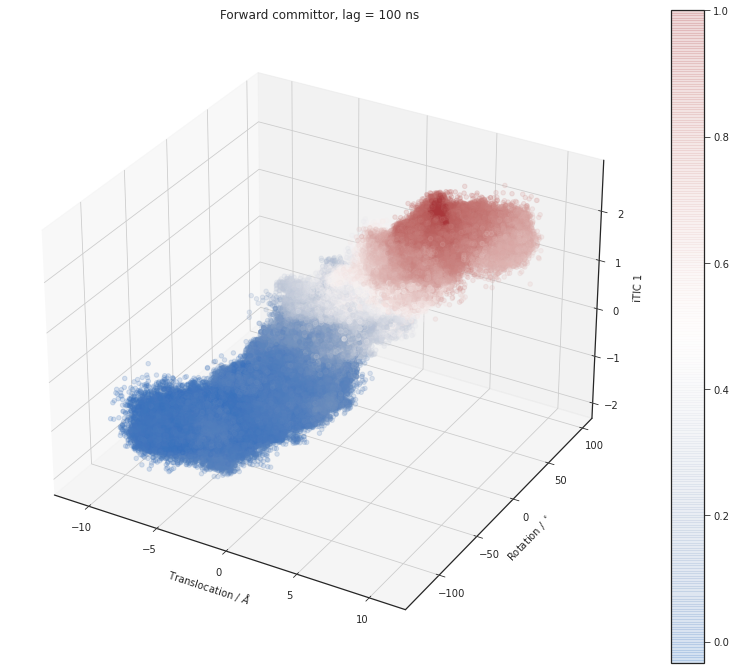

In [145]:
# projection with TIC
f, ax = plt.subplots(figsize=(14, 12), subplot_kw={"projection": "3d"})
q = np.concatenate(q_downup[-1])
h = ax.scatter(
    cv_arr[::10, 0],
    cv_arr[::10, 1],
    livac_arr[::10, 1],
    c=q[::10],
    cmap="vlag",
    alpha=0.2,
)
plt.colorbar(h, ax=ax)
ax.set_title("Forward committor, lag = 100 ns")
ax.set_xlabel("Translocation / $\AA$")
ax.set_ylabel("Rotation / $^\circ$")
ax.set_zlabel("iTIC 1")

In [148]:
# points closest to transition state
# 100 ns lag time
q = np.concatenate(q_downup[-1])
args = ((q - 0.5) ** 2).argsort()
print(args[:10])

[2905560 2363786  388183 2585590 2270527 3371457 3748621 5198621 2375109
 5357106]


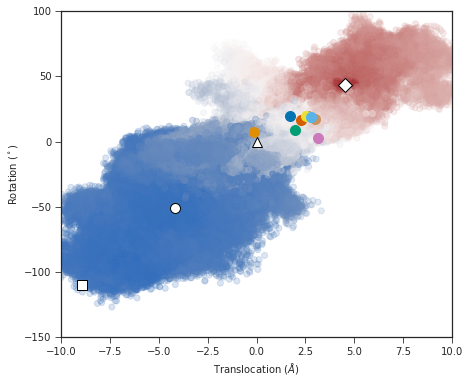

In [150]:
f, ax = plt.subplots(figsize=(7, 6))
ax.scatter(cv_arr[::10, 0], cv_arr[::10, 1], c=q[::10], cmap="vlag", alpha=0.2)
for idx in args[:10]:
    ax.plot(cv_arr[idx, 0], cv_arr[idx, 1], "o", ms=10)
util.format_cvs(ax)

In [153]:
util.frame(388183)

(129, 1183)

## up+-> down transition

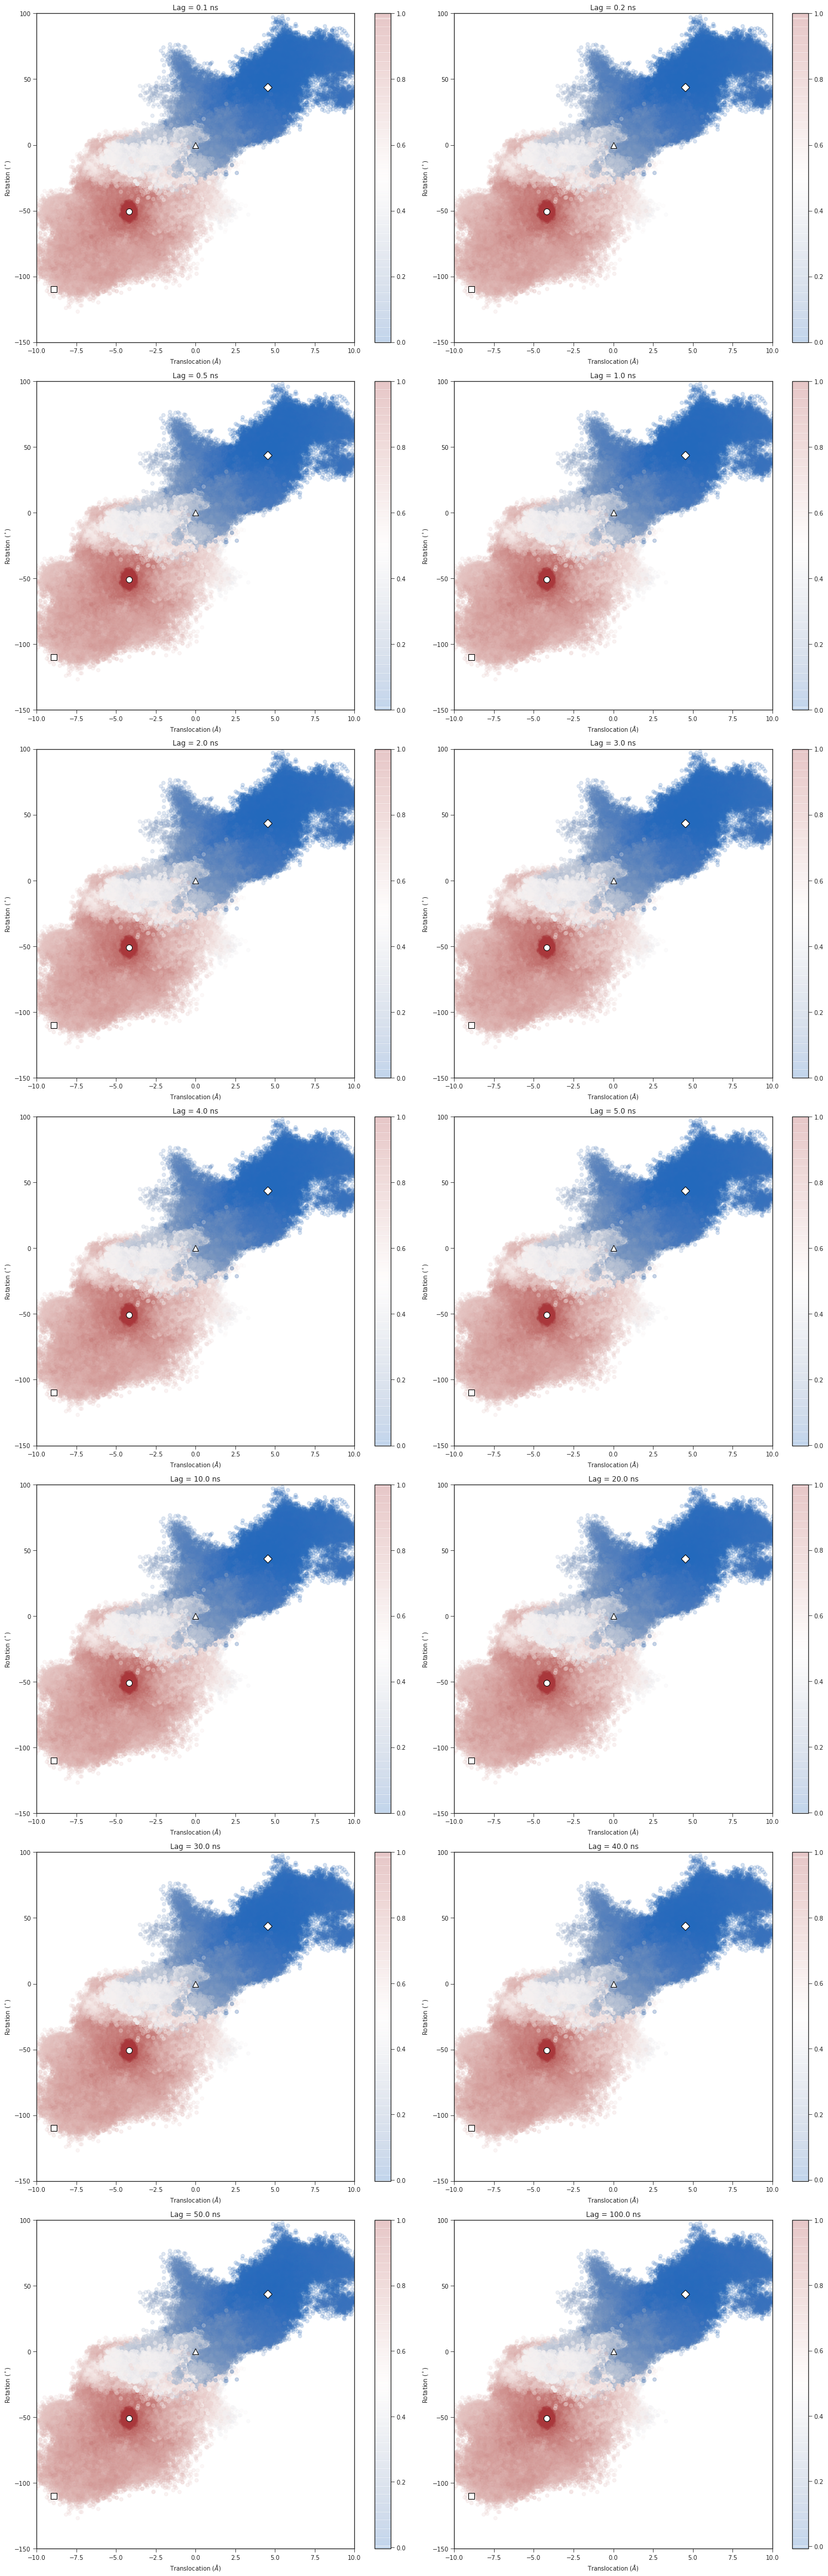

In [140]:
f, axs = plt.subplots(7, 2, figsize=(20, 60))
for lag, q, ax in zip(lags, q_updown, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()

Text(0.5, 0, 'iTIC 1')

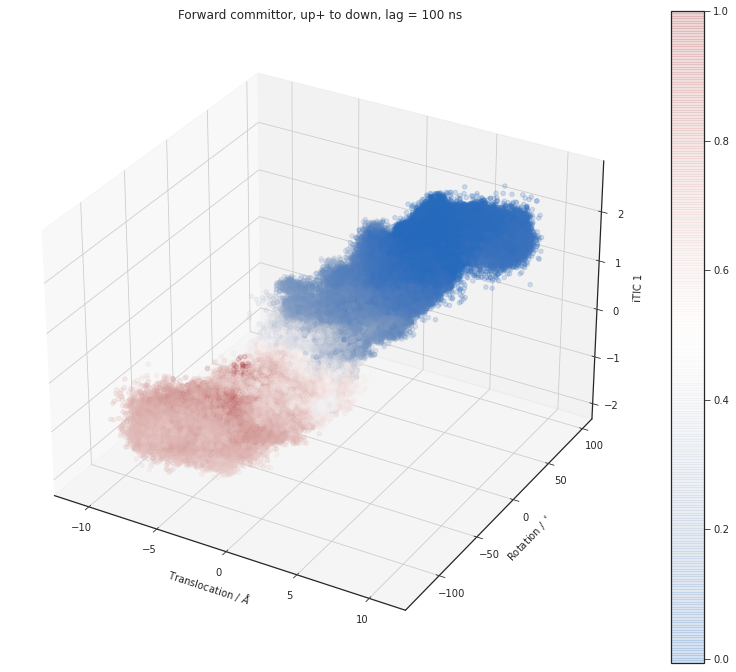

In [147]:
# projection with TIC
f, ax = plt.subplots(figsize=(14, 12), subplot_kw={"projection": "3d"})
q = np.concatenate(q_updown[-1])
h = ax.scatter(
    cv_arr[::10, 0],
    cv_arr[::10, 1],
    livac_arr[::10, 1],
    c=q[::10],
    cmap="vlag",
    alpha=0.2,
)
plt.colorbar(h, ax=ax)
ax.set_title("Forward committor, up+ to down, lag = 100 ns")
ax.set_xlabel("Translocation / $\AA$")
ax.set_ylabel("Rotation / $^\circ$")
ax.set_zlabel("iTIC 1")